## **Libraries**

In [1]:
# === IMPORTS ===
import os
import re
import string
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, silhouette_score, adjusted_rand_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## **Import the Data**

In [2]:
# === DATASET DOWNLOAD & LOADING ===
import kagglehub

# Download dataset and get local path
dataset_path = kagglehub.dataset_download("alexandrakim2201/spotify-dataset")
print("Path to dataset files:", dataset_path)

# List files in dataset folder and find CSV file
files = os.listdir(dataset_path)
print("Available files:", files)

csv_files = [f for f in files if f.endswith(".csv")]

if csv_files:
    data_file_path = os.path.join(dataset_path, csv_files[0])
    data = pd.read_csv(data_file_path)
    print("Dataset loaded successfully!")
    print(data.head())

    # Save a copy locally
    data.to_csv("spotify_dataset_saved.csv", index=False)
    print("Dataset saved as spotify_dataset_saved.csv")
else:
    raise FileNotFoundError("No CSV file found in the dataset.")

Path to dataset files: /kaggle/input/spotify-dataset
Available files: ['DATASET.csv']
Dataset loaded successfully!
                                              Review     label
0  Great music service, the audio is high quality...  POSITIVE
1  Please ignore previous negative rating. This a...  POSITIVE
2  This pop-up "Get the best Spotify experience o...  NEGATIVE
3    Really buggy and terrible to use as of recently  NEGATIVE
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE
Dataset saved as spotify_dataset_saved.csv


## **Exploring the Data**

In [3]:
# === DATA EXPLORATION ===

print("\nDataset info:")
data.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [4]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
Review    16
label      0
dtype: int64


In [5]:
# Drop rows with missing values
data_cleaned = data.dropna()
print("\nMissing values after dropping rows with NaNs:")
print(data_cleaned.isnull().sum())

print(f"\nShape before dropping missing: {data.shape}")
print(f"Shape after dropping missing: {data_cleaned.shape}")


Missing values after dropping rows with NaNs:
Review    0
label     0
dtype: int64

Shape before dropping missing: (52702, 2)
Shape after dropping missing: (52686, 2)


In [6]:
print("\nStatistical description of cleaned data:")
print(data_cleaned.describe())


Statistical description of cleaned data:
       Review     label
count   52686     52686
unique  51472         2
top      Good  NEGATIVE
freq      153     29423


In [7]:
# Check distribution of target labels
label_counts = data_cleaned['label'].value_counts()
print("\nSentiment label distribution:")
print(label_counts)


Sentiment label distribution:
label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64


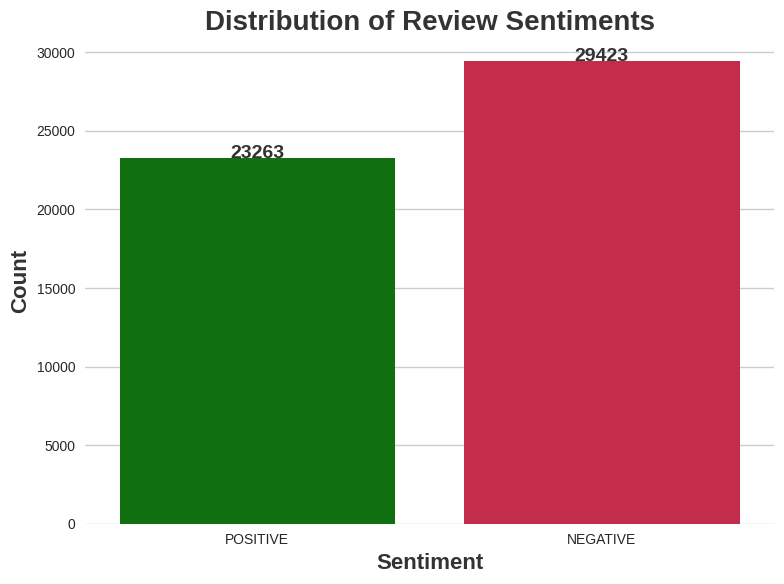

In [8]:
# Plot sentiment distribution
plt.figure(figsize=(8,6))
palette = ['#008000', '#DC143C']  # Emerald green and strawberry red

ax = sns.countplot(x='label', data=data_cleaned, hue='label', palette=palette, dodge=False, legend=False)
plt.title("Distribution of Review Sentiments", fontsize=20, fontweight='bold', color='#333333')
plt.xlabel("Sentiment", fontsize=16, fontweight='bold', color='#333333')
plt.ylabel("Count", fontsize=16, fontweight='bold', color='#333333')

# Add count annotations above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 15, f'{int(height)}',
            ha='center', fontsize=14, fontweight='bold', color='#333333')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

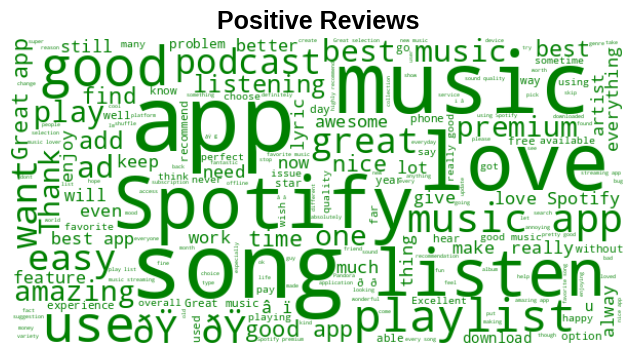

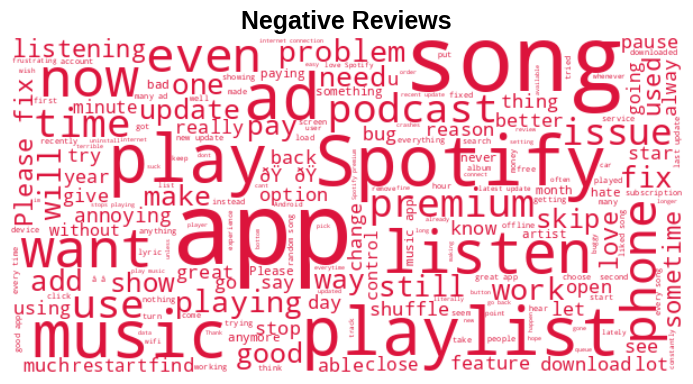

In [9]:
# === WORDCLOUD VISUALIZATION FOR SENTIMENTS ===

# Concatenate all reviews by sentiment
positive_text = ' '.join(data_cleaned[data_cleaned['label'] == 'POSITIVE']['Review'])
negative_text = ' '.join(data_cleaned[data_cleaned['label'] == 'NEGATIVE']['Review'])

# Define custom color functions for word clouds
def emerald_green_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#008000"  # Emerald green

def strawberry_red_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#DC143C"  # Strawberry red

# Generate word clouds
positive_wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=90,
    width=600,
    height=300,
    contour_width=3,
    contour_color='darkgreen',
    colormap=None
).generate(positive_text)

negative_wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=90,
    width=600,
    height=300,
    contour_width=3,
    contour_color='darkred',
    colormap=None
).generate(negative_text)

# Plot positive word cloud
plt.figure(figsize=(8, 4))
plt.imshow(positive_wordcloud.recolor(color_func=emerald_green_color), interpolation="bilinear")
plt.title("Positive Reviews", fontsize=18, fontweight='bold', color="#000000")
plt.axis("off")

# Plot negative word cloud
plt.figure(figsize=(8, 4))
plt.imshow(negative_wordcloud.recolor(color_func=strawberry_red_color), interpolation="bilinear")
plt.title("Negative Reviews", fontsize=18, fontweight='bold', color="#000000")
plt.axis("off")

plt.tight_layout()
plt.show()

## **Preprocessing the Data**

In [10]:
# === TEXT PREPROCESSING ===

# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Custom stopwords specific to the domain
custom_stopwords = {'spotify', 'music', 'song', 'songs', 'app'}

# Define stopwords set with negation exceptions
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}

# Merge stopwords with custom ones
all_stopwords = stop_words.union(custom_stopwords)

def clean_text(text):
    """
    Clean and preprocess text by:
    - Removing non-ascii characters
    - Lowercasing
    - Removing punctuation and digits
    - Removing stopwords (with exceptions)
    - Stripping leading and trailing spaces
    """
    # Remove non-ascii characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([c for c in text if not c.isdigit()])
    # Keep only alphabetic characters and spaces
    text = ''.join(filter(lambda x: x.isalpha() or x.isspace(), text))
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in all_stopwords]
    cleaned_text = ' '.join(tokens)
    # Strip leading and trailing spaces
    return cleaned_text.strip()


# Apply cleaning function to review texts
data_cleaned['Cleaned_Review'] = data_cleaned['Review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


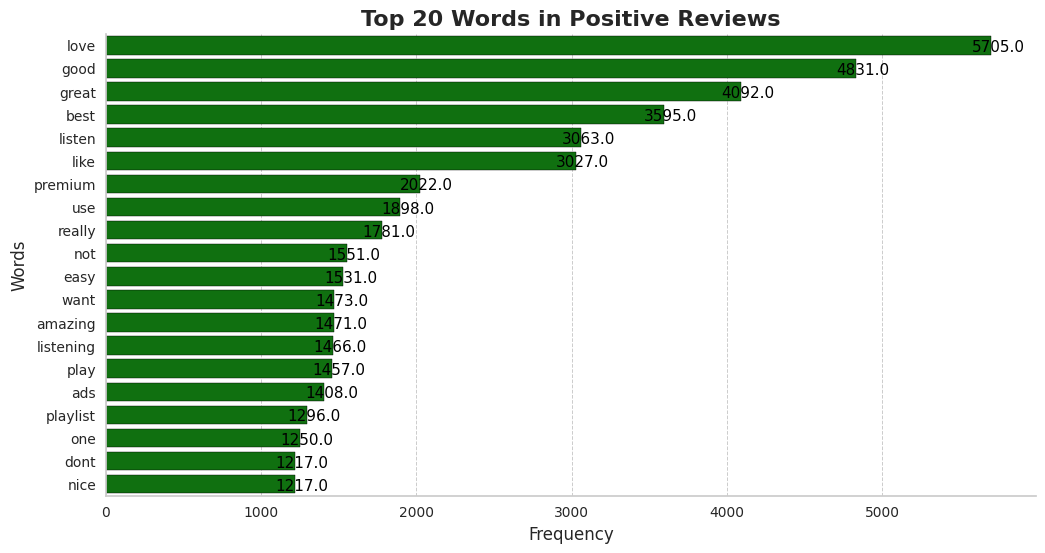

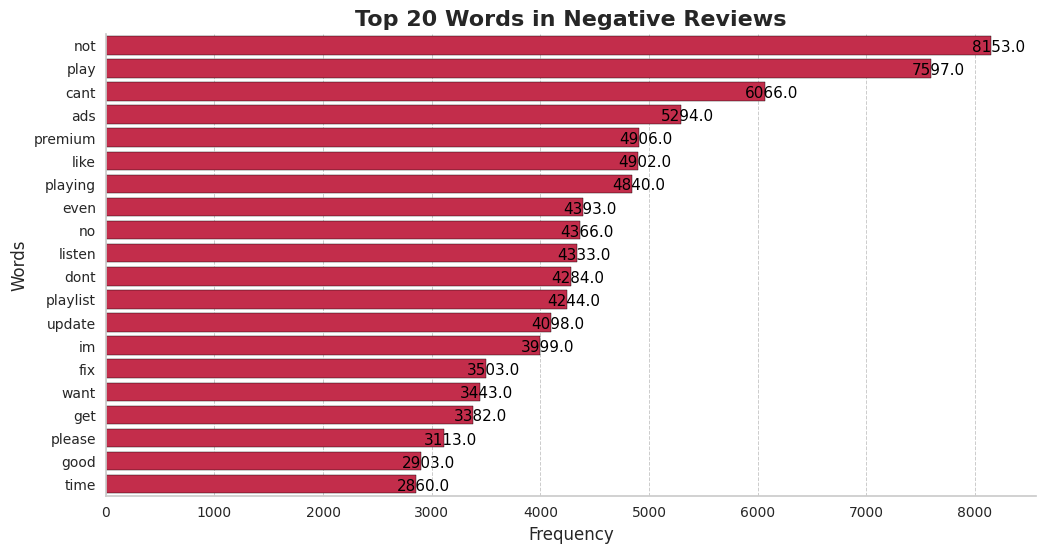

In [11]:
# === TOP WORDS ANALYSIS ===

sns.set_style("whitegrid")

def get_top_words(text_series, n=20):
    """
    Extract top n most frequent words from a series of texts.
    """
    all_words = ' '.join(text_series)
    tokens = all_words.split()
    counter = Counter(tokens)
    return counter.most_common(n)

# Get top 20 words for each sentiment
top_positive = get_top_words(data_cleaned[data_cleaned['label'] == 'POSITIVE']['Cleaned_Review'], 20)
top_negative = get_top_words(data_cleaned[data_cleaned['label'] == 'NEGATIVE']['Cleaned_Review'], 20)

def plot_top_words(top_words, title, color):
    """
    Plot a horizontal bar chart of the most frequent words.
    """
    words, counts = zip(*top_words)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(counts), y=list(words), color=color, edgecolor='black')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)

    # Annotate bars with count values
    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center_baseline', fontsize=11, color='black', xytext=(5, 0),
                    textcoords='offset points')

    sns.despine()
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
    plt.show()

# Colors for plots
emerald_green = '#008000'
strawberry_red = '#DC143C'

# Plot top words for positive and negative reviews
plot_top_words(top_positive, 'Top 20 Words in Positive Reviews', emerald_green)
plot_top_words(top_negative, 'Top 20 Words in Negative Reviews', strawberry_red)

## **Word2Vec**

In [12]:
# Ensure gensim is installed
# If needed, uncomment below:
#!pip install gensim

import numpy as np
from gensim.models import Word2Vec

# --- Tokenize the cleaned reviews ---
tokenized_reviews = data_cleaned['Cleaned_Review'].apply(lambda x: x.split())

# --- Train Word2Vec Model ---
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,       # Dimensionality of the word vectors
    window=5,              # Context window size
    min_count=2,           # Minimum frequency for a word to be included
    workers=4,             # Number of threads to use
    sg=1                   # Use Skip-gram (1) instead of CBOW (0)
)

# Train the model (optional if already trained during instantiation)
w2v_model.train(tokenized_reviews, total_examples=len(tokenized_reviews), epochs=10)

# --- Helper Function: Average Word2Vec Embeddings ---
def get_average_word2vec(tokens, model, vector_size):
    """
    Compute the average Word2Vec embedding for a list of tokens.
    If none of the tokens are in the model vocabulary, returns a zero vector.
    """
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

# --- Apply average embeddings to dataset ---
data_cleaned['W2V_Vector'] = tokenized_reviews.apply(
    lambda tokens: get_average_word2vec(tokens, w2v_model, vector_size=100)
)

## **Text Classification**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

In [14]:
# -------------------------------------
# 1. Prepare features and labels
# -------------------------------------
X = np.vstack(data_cleaned['W2V_Vector'].values)  # Convert Word2Vec vectors to a feature matrix
y = data_cleaned['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})  # Encode target: POSITIVE → 1, NEGATIVE → 0


In [15]:
# -------------------------------------
# 2. Train-test split
# -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [16]:
# -------------------------------------
# 3. Define and evaluate classifiers
# -------------------------------------

models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42)
}


In [17]:
# -------------------------------------
# 4. Train, predict, and evaluate
# -------------------------------------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))  # More decimal precision
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.10f}")


=== XGBoost ===
Classification Report:
              precision    recall  f1-score   support

           0     0.8826    0.8980    0.8903      5885
           1     0.8681    0.8489    0.8584      4653

    accuracy                         0.8764     10538
   macro avg     0.8754    0.8735    0.8743     10538
weighted avg     0.8762    0.8764    0.8762     10538

Accuracy: 0.8763522490

=== SVM ===
Classification Report:
              precision    recall  f1-score   support

           0     0.8744    0.9094    0.8916      5885
           1     0.8793    0.8347    0.8564      4653

    accuracy                         0.8764     10538
   macro avg     0.8768    0.8721    0.8740     10538
weighted avg     0.8766    0.8764    0.8761     10538

Accuracy: 0.8764471437

=== MLP ===
Classification Report:
              precision    recall  f1-score   support

           0     0.8775    0.8960    0.8867      5885
           1     0.8649    0.8418    0.8532      4653

    accuracy            

In [18]:
# ================================================
# Train Best Model (SVM with Word2Vec)
# ================================================

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train the best classifier (SVM in this case)
best_model = SVC(kernel='linear', probability=True)
best_model.fit(X_train, y_train)

# Predict on test set
y_pred = best_model.predict(X_test)

# Print detailed classification report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred, digits=5))

# Print full accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Full Accuracy: {accuracy:.10f}")


SVM Classification Report:
              precision    recall  f1-score   support

           0    0.87437   0.90943   0.89155      5885
           1    0.87933   0.83473   0.85645      4653

    accuracy                        0.87645     10538
   macro avg    0.87685   0.87208   0.87400     10538
weighted avg    0.87656   0.87645   0.87605     10538

Full Accuracy: 0.8764471437


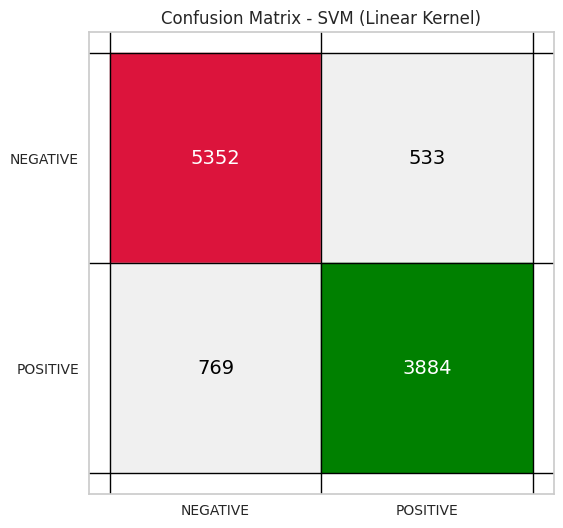

In [19]:
# ========================================
# Confusion Matrix Visualization
# ========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])  # 0 = NEGATIVE, 1 = POSITIVE

fig, ax = plt.subplots(figsize=(6, 6))

# Define colors: green for TP, red for TN, neutral gray for others
colors = np.full(cm.shape, '#f0f0f0')
colors[0, 0] = '#DC143C'  # True Negative
colors[1, 1] = '#008000'  # True Positive

# Draw the matrix with colored cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.fill_between([j, j+1], i, i+1, color=colors[i, j])

# Add cell values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if colors[i,j] in ['#008000', '#DC143C'] else 'black'
        ax.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color=color, fontsize=14)

# Set axis labels
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['NEGATIVE', 'POSITIVE'])
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(['NEGATIVE', 'POSITIVE'])

# Draw cell borders
for i in range(3):
    ax.axhline(i, color='black', linewidth=1)
    ax.axvline(i, color='black', linewidth=1)

ax.invert_yaxis()
ax.grid(False)
plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.show()


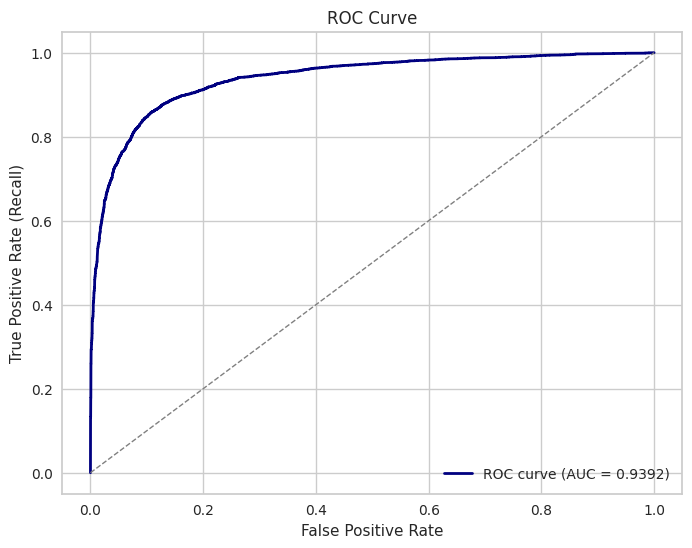

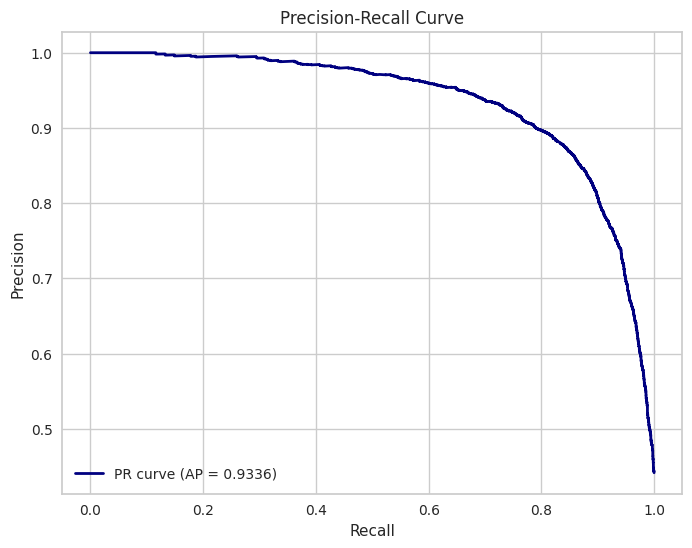

In [20]:
# ====================================
# ROC & PR Curve Evaluation
# ====================================

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Binary label conversion if needed
# (Assume y_test is already binary if y was mapped correctly before)
y_scores = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='#000080', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='#000080', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


## **Text Clustering**

k = 2, Silhouette Score = 0.1582
k = 3, Silhouette Score = 0.0619
k = 4, Silhouette Score = 0.0579
k = 5, Silhouette Score = 0.0567
k = 6, Silhouette Score = 0.0502
k = 7, Silhouette Score = 0.0462
k = 8, Silhouette Score = 0.0502
k = 9, Silhouette Score = 0.0443
k = 10, Silhouette Score = 0.0475


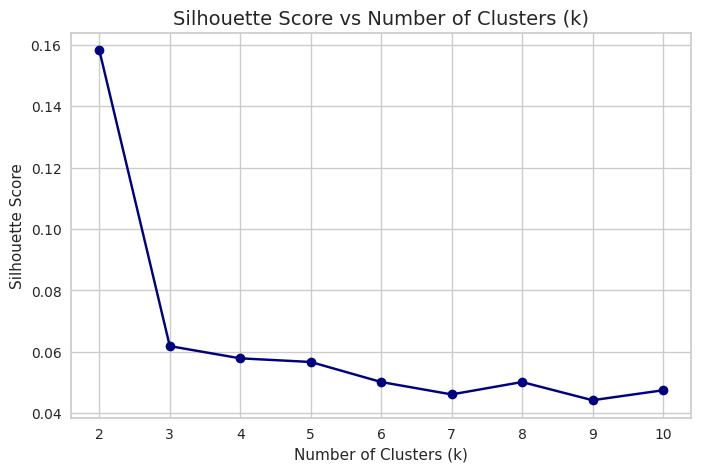

In [25]:
# ===================================================
# Silhouette Score Analysis for k Clusters
# ===================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Try different values of k to identify optimal number of clusters
k_values = range(2, 11)
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    sil_scores.append(score)
    print(f'k = {k}, Silhouette Score = {score:.4f}')

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o', color='#000080')
plt.title('Silhouette Score vs Number of Clusters (k)', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [26]:
# ========================================
# Clustering with KMeans (k=2)
# ========================================

# Apply KMeans with k=2 (assumed: POSITIVE vs NEGATIVE clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

# Assign clusters to the DataFrame
data_cleaned['Cluster'] = clusters

# Evaluate clustering quality
silhouette = silhouette_score(X, clusters)
print(f"Silhouette Score (k=2): {silhouette:.4f}")


Silhouette Score (k=2): 0.1582


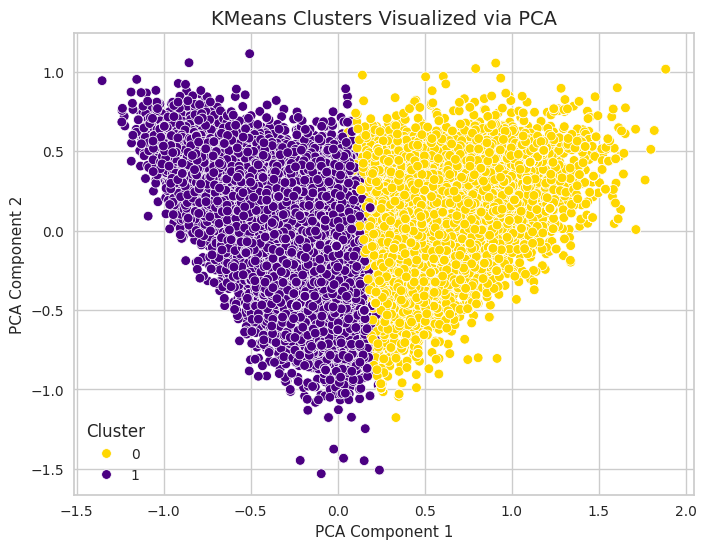

In [27]:
# =====================================
# PCA Visualization of Clusters
# =====================================

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=data_cleaned['Cluster'],
                palette=['#FFD700', '#4B0082'])
plt.title("KMeans Clusters Visualized via PCA", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [28]:
# ==========================================
# Evaluation Against True Labels
# ==========================================

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Compare clustering labels with true sentiment labels
ari = adjusted_rand_score(data_cleaned['label'], clusters)
nmi = normalized_mutual_info_score(data_cleaned['label'], clusters)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 0.4289
Normalized Mutual Information (NMI): 0.3590


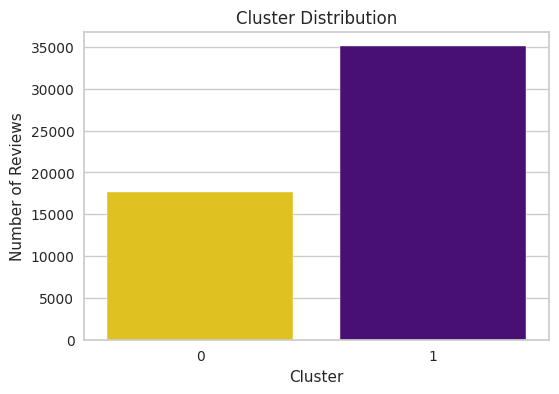


Cross-tabulation (True Label vs Cluster):
Cluster       0      1    All
label                        
NEGATIVE   1717  27706  29423
POSITIVE  15907   7356  23263
All       17624  35062  52686


In [29]:
# ===================================
# Cluster Distribution Plot
# ===================================

# Barplot for cluster counts
plt.figure(figsize=(6, 4))
sns.countplot(x=data_cleaned['Cluster'], palette=['#FFD700', '#4B0082'])
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

# Optional: Crosstab with true labels
print("\nCross-tabulation (True Label vs Cluster):")
print(pd.crosstab(data_cleaned['label'], data_cleaned['Cluster'], margins=True))


In [30]:
# ======================================
# Additional Cluster Metrics
# ======================================

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

calinski = calinski_harabasz_score(X, clusters)
davies = davies_bouldin_score(X, clusters)

print(f"Calinski-Harabasz Score: {calinski:.2f}")
print(f"Davies-Bouldin Score: {davies:.4f}")


Calinski-Harabasz Score: 6976.87
Davies-Bouldin Score: 2.5613


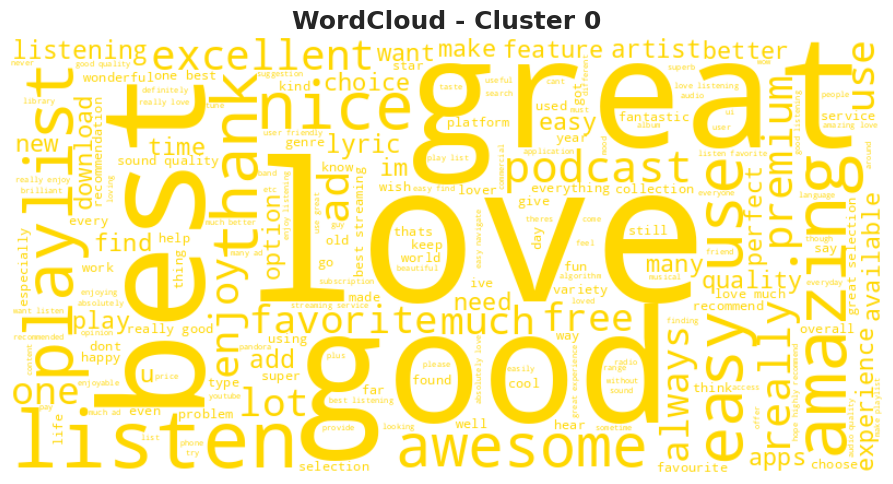

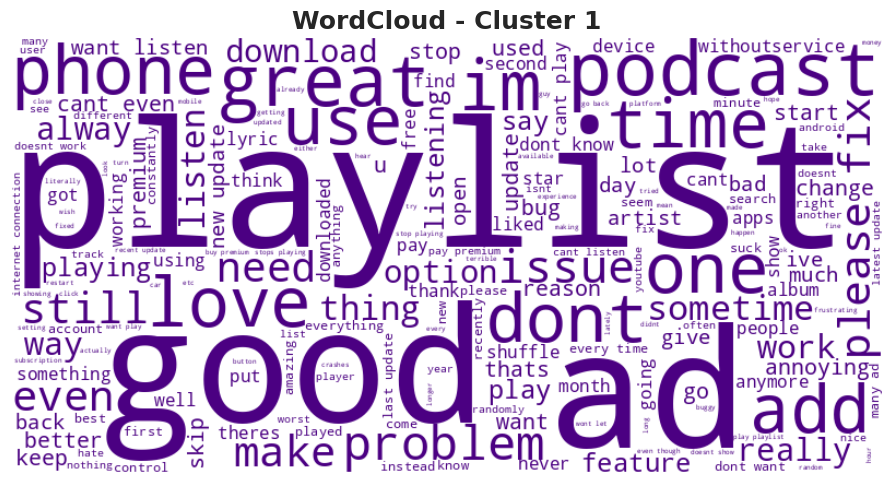

In [31]:
# ==================================
# WordCloud per Cluster
# ==================================

from wordcloud import WordCloud

# Define colors for clusters
cluster_colors = ['#FFD700', '#4B0082']

# Generate word clouds
n_clusters = data_cleaned['Cluster'].nunique()

for i in range(n_clusters):
    cluster_text = ' '.join(data_cleaned[data_cleaned['Cluster'] == i]['Cleaned_Review'])

    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        width=800,
        height=400,
        contour_width=2,
        contour_color='black'
    ).generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(
        wordcloud.recolor(color_func=lambda *args, **kwargs: cluster_colors[i % len(cluster_colors)]),
        interpolation='bilinear'
    )
    plt.axis('off')
    plt.title(f"WordCloud - Cluster {i}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()


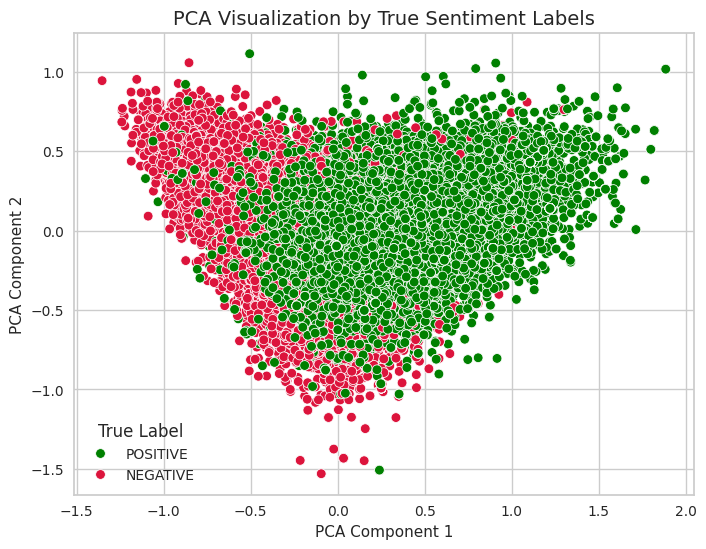

In [32]:
# =========================================
# True Labels Visualized via PCA
# =========================================

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=data_cleaned['label'],
                palette={'POSITIVE': '#008000', 'NEGATIVE': '#DC143C'})
plt.title("PCA Visualization by True Sentiment Labels", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='True Label')
plt.grid(True)
plt.show()
